# Байесовская статистика: Задача о разведке

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots
from IPython.core.pylabtools import figsize
plt.style.use(['science', 'notebook', 'grid', 'ggplot'])

import numpy as np
import scipy.stats as stats

__Артиллерийскому дивизиону__ был дан приказ уничтожить предполагаемого противника. Для этого ему была выделена информация со спутника, где предполагаемый противник находился в точке $  X_0 = 0  $.  Поскольку информация не была актуальной, мы можем предположить,  
что предполагаемое местоположение противника подчинено закону $  P(X) \sim \mathcal{N}(0, 8)$

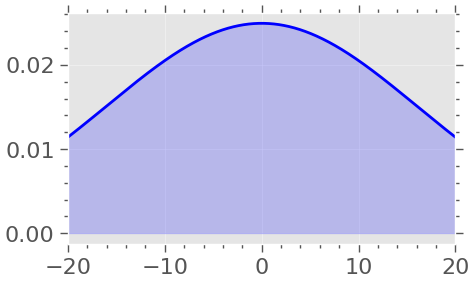

In [2]:
def plot_continuous_dist(x, y, x_lim = (-20, 20)):
    plt.figure(figsize=(5,3))
    plt.xlim(x_lim)
    plt.plot(x, y, color='blue')
    plt.fill_between(x, y, color='blue', alpha=0.2)
    plt.show()

x = np.linspace(-20,20, 1000)
x_dist = stats.norm.pdf(x,loc = 0, scale = 16)

plot_continuous_dist(x, x_dist)

Далее разведывательный взвод доложил, что предполагаемый противник был обнаружен в точке $  X_1 = 2  $, при том что взвод указывал местоположение из распределения $ X_1 = Y_0(X) \in \mathcal{N}(X, 4)  $, так как местоположение было указано приблизительно и противник за время доклада мог сменить местоположение.

Пересчитаем наше априорное распределение вероятности местоположения $  X  $ по теореме Байеса:
$  P(X|Y) = \frac{P(Y|X) \cdot P(X)}{P(Y)} \propto P(Y|X) \cdot P(X) \propto EXP\left[-\frac{(Y_0-X)^2}{4^2}\right] \cdot P(X)  $

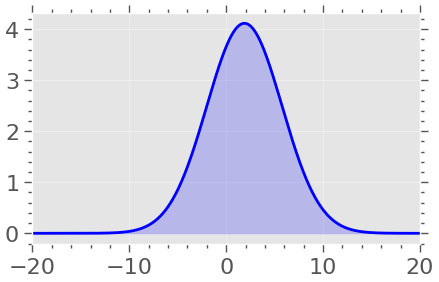

In [3]:
def bayes_posterior(y_obs, x, x_dist, sigma):
    x_dist = x_dist*stats.norm.pdf(y_obs, loc = x, scale = sigma)
    x_dist /= np.sum(x_dist)/x.size
    return x_dist

y_obs = 2
x_dist = bayes_posterior(y_obs, x,x_dist, 4)
plot_continuous_dist(x,x_dist, x_lim=(-20,20))

## SymPy

Также получить данное распределение можно __"руками"__, просто перемножив 2 нормальных распределения, проделаем данные операции используя библиотеку символьных вычислений sympy

In [4]:
from sympy import symbols, simplify, expand, integrate, sqrt
from sympy.stats import Normal, density

# Определяем переменную
x = symbols('x')

# Определяем два нормальных распределения
N1 = Normal('P(X)', 0, 8)  # Среднее 0, стандартное отклонение 8
N2 = Normal('P(Y|X)', 2, 4)   # Среднее 2, стандартное отклонение 4

# Получаем функции плотности вероятности для каждого распределения
PX = density(N1)(x)
PY_on_X = density(N2)(x)

# Перемножаем две функции плотности вероятности
product_density = PX * PY_on_X

# получаем интегралл P(Y) за счет интегрирования
PY = integrate(product_density, (x,-np.inf, np.inf))

#Получаем апостериорно P(X|Y)
posterior_density = simplify(expand(product_density/PY))

posterior_density

sqrt(10)*exp(-5*x**2/128 + x/8 - 1/10)/(16*sqrt(pi))

In [5]:
#проверим что площадь под графиком распределения равна 1
integrate(posterior_density, (x,-np.inf, np.inf)).cancel()

1

Мы получили также нормальное распределение попробуем высчитать его мат ожидание и дисперсию свернув полный квадрат под экспонентой

In [6]:
#Получаем выражение под экспонентой
expression = posterior_density.args[3].args[0]
expression

-5*x**2/128 + x/8 - 1/10

In [7]:
from sympy import symbols, solve

# Определяем переменные
mu, sigma, c = symbols('mu, sigma,c')

#желаем превратиь наше выражение в полный квадрат вида:
exp = -(x-mu)**2/2/sigma**2+c

result = solve(expression - exp, mu,sigma**2,c)

result

{c: 0, mu: 8/5, sigma**2: 64/5}

In [8]:
#выражение под экспонентой после выделения полного квадрата
exp.subs(result)

-5*(x - 8/5)**2/128

Получаем $X|Y \in \mathcal{N}(\mu = 1.6;\ \sigma = \frac{8}{\sqrt5}\approx 3.58)$  
Так как нормальное распределение является сопряженным к себе самому, мы апостериорно всегда будем получать нормальное распределение, точную формулу пересчета математического ожидания, и дисперсии можно посмотреть [тут](https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D0%BF%D1%80%D1%8F%D0%B6%D1%91%D0%BD%D0%BD%D0%BE%D0%B5_%D0%B0%D0%BF%D1%80%D0%B8%D0%BE%D1%80%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5)  
  
Также среднее и дисперсию можно получить путем интегрирования

In [9]:
from sympy import Eq
mean = integrate(x*posterior_density, (x,-np.inf, np.inf)).cancel()
Eq(mu, mean)

Eq(mu, 8/5)

In [10]:
Var = integrate((x-mean)**2*posterior_density, (x,-np.inf, np.inf)).cancel()
std = sqrt(Var)
Eq(sigma, std)

Eq(sigma, 8*sqrt(5)/5)

In [11]:
#Проверка равенства распределений
simplify(Eq(density(Normal('X|Y', mean, std))(x), posterior_density))

True

Мы также можем построить график функции преобразовав формулу апостериорного распределения в лямбда функцию

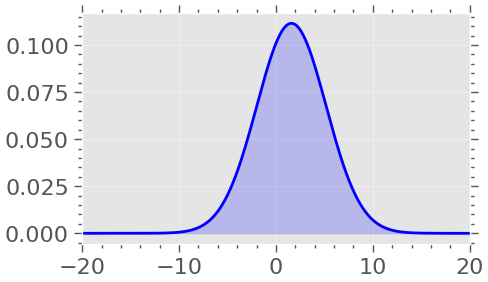

In [12]:
from sympy.utilities.lambdify import lambdify

#Создаем люмбда функцию которая будет являтся нашей фунцией распредления из формулы
posterior_X_density = lambdify(x, posterior_density, 'numpy')

x_cords = np.linspace(-20,20, 1000)
x_dist = posterior_X_density(x_cords)

plot_continuous_dist(x_cords, x_dist)

## SciPy

Также можно посчитать апостериорную оценку используя библиотеку __SciPy__

In [13]:
from scipy.integrate import quad

# Определяем два нормальных распределения
N1 = stats.norm(loc = 0, scale = 8)
N2 = stats.norm(loc = 2, scale = 4)

# Функция для перемножения плотностей
product_density= lambda x: N1.pdf(x) * N2.pdf(x)

# получаем интегралл P(Y) за счет интегрирования
PY, _ = quad(product_density, -np.inf, np.inf)

#Получаем апостериорное распределение P(X|Y)
posterior_density = lambda x: product_density(x)/PY

#Проверим площадь что площадь под графиком функции распределения равна 1
quad(posterior_density, -np.inf, np.inf)[0]

0.9999999999999999

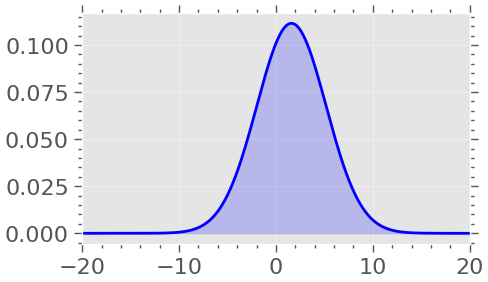

In [14]:
x_cords = np.linspace(-20,20, 1000)
x_dist = posterior_density(x_cords)

plot_continuous_dist(x_cords, x_dist)

Можно расчитать среднее и СКО распределения:

In [15]:
mean = quad(lambda x: x*posterior_density(x), -np.inf, np.inf)[0]
mean

1.6000000000000012

In [16]:
Var = quad(lambda x: (x-mean)**2*posterior_density(x), -np.inf, np.inf)[0]
std = np.sqrt(Var)
std

3.5777087639996634

Был пущен разведывательный дрон для патрулирования окрестности предположительного местоположения противника, дрон обнаружил противника в точке $  X_2 = 1.4$ после чего был сбит, предполагаем что местоположение получено из распределения $ X_2 = Y_1(X) \in \mathcal{N}(X, 2)$.  
Пересчитаем апостериорное распределение:

In [17]:
# # Определяем новое нормальное распределение
# N3 = stats.norm(loc=1.4, scale=1)

# # Функция для перемножения плотностей с новым распределением
# new_product_density = lambda x: posterior_density(x) * N3.pdf(x)

# # Получаем интеграл нового распределения за счет интегрирования
# PY2, _= quad(new_product_density, -np.inf, np.inf)

# # Получаем новое апостериорное распределение P(X|Y) с учетом нового распределения
# new_posterior_density = lambda x: new_product_density(x) / PY2

# # Проверяем, что площадь под графиком новой функции распределения равна 1
# quad(new_posterior_density, -np.inf, np.inf)[0]

In [18]:
N1 = stats.norm(loc = mean, scale = std)
N2 = stats.norm(loc = 1.4, scale = 2)

product_density= lambda x: N1.pdf(x) * N2.pdf(x)

PY, _ = quad(product_density, -np.inf, np.inf)

posterior_density = lambda x: product_density(x)/PY

quad(posterior_density, -np.inf, np.inf)[0]

0.9999999999999999

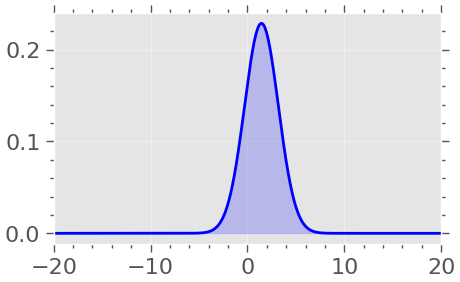

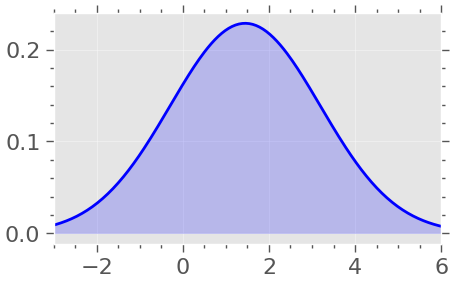

In [19]:
x_cords = np.linspace(-20,20, 1000)
x_dist = posterior_density(x_cords)

plot_continuous_dist(x_cords, x_dist)
plot_continuous_dist(x_cords, x_dist, x_lim= (-3,6))

In [20]:
new_mean = quad(lambda x: x*posterior_density(x), -np.inf, np.inf)[0]
new_Var = quad(lambda x: (x-mean)**2*posterior_density(x), -np.inf, np.inf)[0]
new_std = np.sqrt(new_Var)
print("mu = ", new_mean)
print("sigma = ", new_std)

mu =  1.4476190476190478
sigma =  1.7523809523809522


После чего получаем еще одно нормальное распределение, построим для него 80% доверительный интервал местоположения противника

In [21]:
stats.norm.interval(0.8, loc=new_mean, scale=new_std)

(-0.7981475053352991, 3.6933856005733947)

Командира дивизиона устаивал выбранный интервал для артиллерийского огня, после чего была отдана команда __"Огонь по цели"__, в результате которой противник был уничтожен.

Также можно смоделировать распределение нового Y, дрона который передаст предпологаемое местоположение об уничтоженном противнике из распределениея $\mathcal{N}(X, 1)$  
$P(Y) = \int \limits_x P(Y \cap X) \delta x = \int \limits_x P(Y|X)P(X) dx$  
Правдоподобие $P(Y|X) = \frac{1}{\sqrt{2\pi}}EXP[\frac{-(Y-X)^2}{2}]$  
Апостериорное распределение $P(X) = \frac{1}{\sqrt{2\pi\sigma^2}}EXP[\frac{-(X-\mu)^2}{2\sigma^2}]$

In [22]:
x, y = symbols('x, y')

N1 = Normal('P(X)', new_mean, new_std) 
N2 = Normal('P(Y|X)', x, 1)

PX = density(N1)(x)
PY_on_X = density(N2)(y)

product_density = PX * PY_on_X

# получаем искомый интегралл P(Y)
PY = integrate(product_density, (x,-np.inf, np.inf))

PY = simplify(PY)

PY

0.270931320458907*exp(y*(0.355607049753793 - 0.122824803368909*y))/sqrt(pi)

In [23]:
#проверим что площадь под графиком распределения равна 1
integrate(PY, (y,-np.inf, np.inf)).cancel()

1.00000000000000

Расчитаем среднее и дисперсию распределения:

In [24]:
Y_mean = integrate(y*PY, (y,-np.inf, np.inf)).cancel()
Eq(mu, Y_mean)

Eq(mu, 1.44761904761905)

In [25]:
Y_var = integrate((y-Y_mean)**2*PY, (y,-np.inf, np.inf)).cancel()
Y_std = sqrt(Y_var)
Eq(sigma, Y_std.evalf())

Eq(sigma, 2.01763202845999)

Дисперсия получилась высокой, поскольку в расчеты не была включена вероятность поражения цели. Чтобы снизить дисперсию, можно было бы пересчитать вероятность, учитывая проведенную стрельбу. Если стрельба осуществлялась по зоне с распределением $\mathcal{N}(X, 1)$ несколькими орудиями, следует также принимать во внимание радиус поражения. Однако включение этих факторов может существенно усложнить задачу, что нецелесообразно для базового примера.

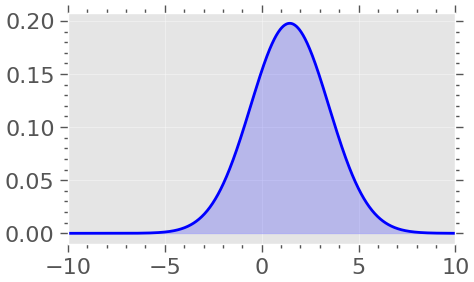

In [26]:
y_cords = np.linspace(-10,10, 1000)
y_dist = stats.norm.pdf(y_cords,loc = np.float64(Y_mean), scale = np.float64(Y_std))

plot_continuous_dist(y_cords,y_dist, x_lim=(-10,10))

Можно было сделать аналогично используя __SciPy__, но вычислительно сложнее так как мы не используем явной формулы

In [27]:
def px(x):
    return stats.norm.pdf(x, loc=new_mean, scale=new_std)

def py_on_x(y, x):
    return stats.norm.pdf(y, loc=x, scale=1)

def product_dist(y):
    return quad(lambda x: px(x) * py_on_x(y, x), -np.inf, np.inf)[0]

y_cords = np.linspace(-10,10, 1000)
y_dist = np.array([product_dist(y) for y in y_cords])

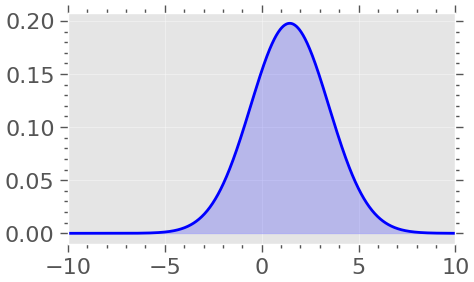

In [28]:
plot_continuous_dist(y_cords,y_dist, x_lim=(-10,10))

Напоследок построим график совместного распределения $P(Y \cap X)$

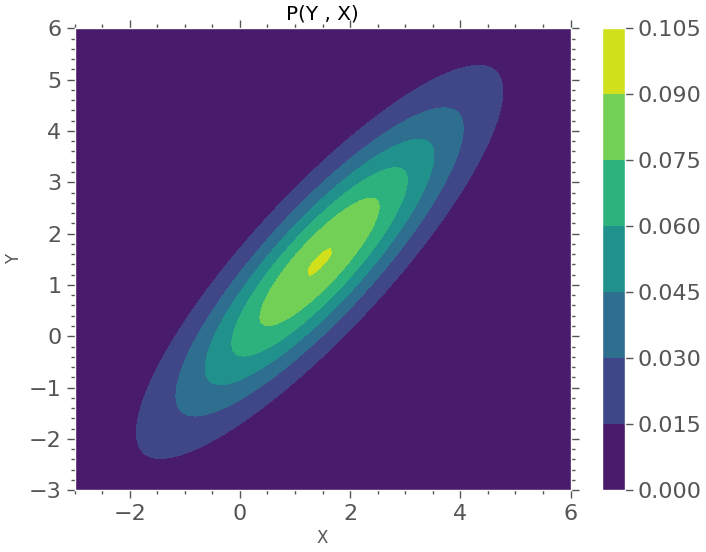

In [29]:
product_density_func = lambdify((x, y), product_density, 'numpy')

# Создаем сетку значений для x и y
x_vals = np.linspace(-3, 6, 100)
y_vals = np.linspace(-3, 6, 100)
X, Y = np.meshgrid(x_vals, y_vals)

# Вычисляем значения совместного распределения на сетке
Z = product_density_func(X, Y)

# Визуализация совместного распределения с использованием цветовой карты
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('P(Y , X)')
plt.show()

Интегрируя функцию плотности вероятности, представленную на этом графике, по оси X, мы получаем маргинальное распределение P(Y) для переменной Y. Аналогично, интегрируя по оси Y, мы находим маргинальное распределение P(X) для переменной X.